In [1]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,6],[21,4],
                 [16,11],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [31, 23],[48, 28],#(13, -13)
                 [62, 78],[78, 70]])#+(20, 35)

sub_regions = [[25,0,10,0],
               [30,10, 25, 9],
               [20,0, 40, 17],
               [50, 25, 15, 3],
               [53, 26, 33, 18],
               [80, 57, 80, 65]]


x_max = 80
x_min = 0
y_max = 80
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.10/beta]
print(els)

0.0625
[2.4, 2.4, 2.4, 2.4, 2.4, 1.6]


In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [5]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 250 samples from Channel 1
Completed PredictedChannel 1
Drawing 250 samples from Channel 2
Completed PredictedChannel 2
Drawing 320 samples from Channel 3
Completed PredictedChannel 3
Drawing 320 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 405 samples from Channel 9
Completed PredictedChannel 9
Drawing 405 samples from Channel 10
Completed PredictedChannel 10
Drawing 345 samples from Channel 11
Completed PredictedChannel 11
Drawing 345 samples from Channel 12
Completed PredictedChannel 12
[0.5849514563106796, 0.8203445447087777, 0.8040071414401905, 0.859395532194481, 0.8022886204704387, 0.850040749796251]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


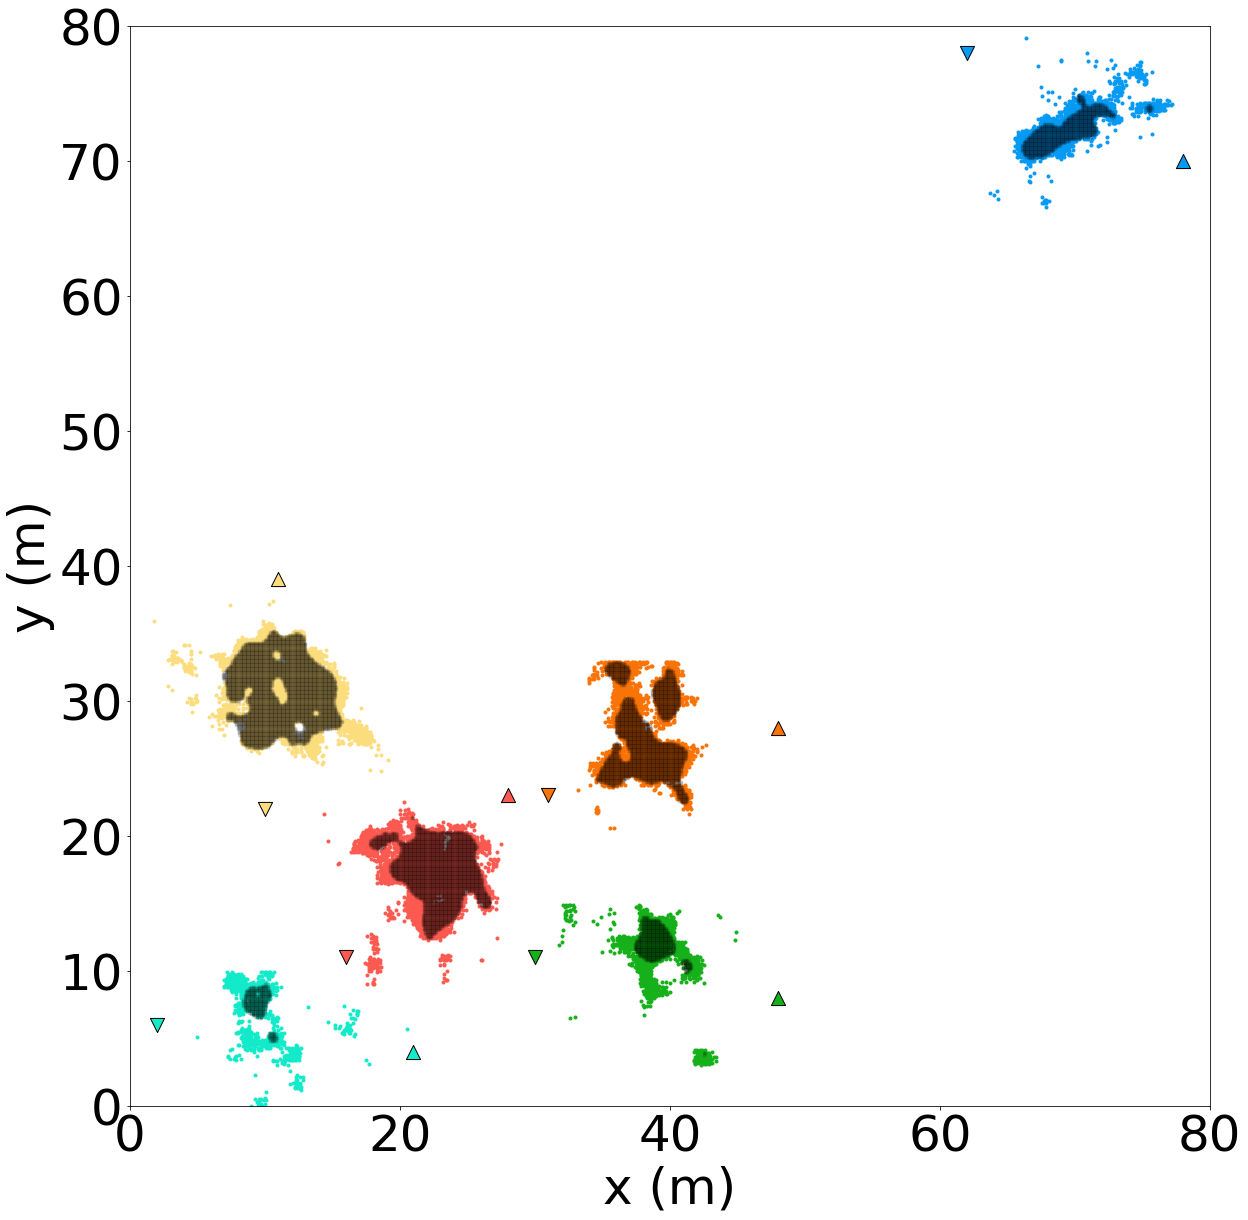

In [6]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [7]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
4 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Found hole
Found hole
Found hole
Found hole
Constructed 1 possibly non-convex polygons
33 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
9 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([36.1 26.9])  ([36.  26.9])  ([35.9 26.8])  ([35.8 26.7])  ([35.8 26.6])  ([35.8 26.5])  ([35.8 26.4])  ([35.7 26.2])  ([35.6 26. ])  ([35.5 25.9])  ([35.4 25.8])  ([35.3 25.7])  ([35.2 25.5])  ([35.1 25.3])  ([35.  25.1])  ([34.9 25. ])  ([34.8 24.8])  ([34.7 24.6])  ([34.7 24.5])  ([34.6 24.3])  ([34.6 24.2])  ([34.6 24.1])  ([34.7 24. ])  ([34.8 24. ])  ([34.9 24. ]) 

Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 195.71
Working on Permutation (0, 1, 2, 3, 5, 4)
Optimal Solution Improved to 194.93
Working on Permutation (0, 1, 2, 4, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3)
Optimal Solution Improved to 182.45
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
Optimal Solution Improved to 180.32
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
Optimal Solution Improved to 178.42
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5, 

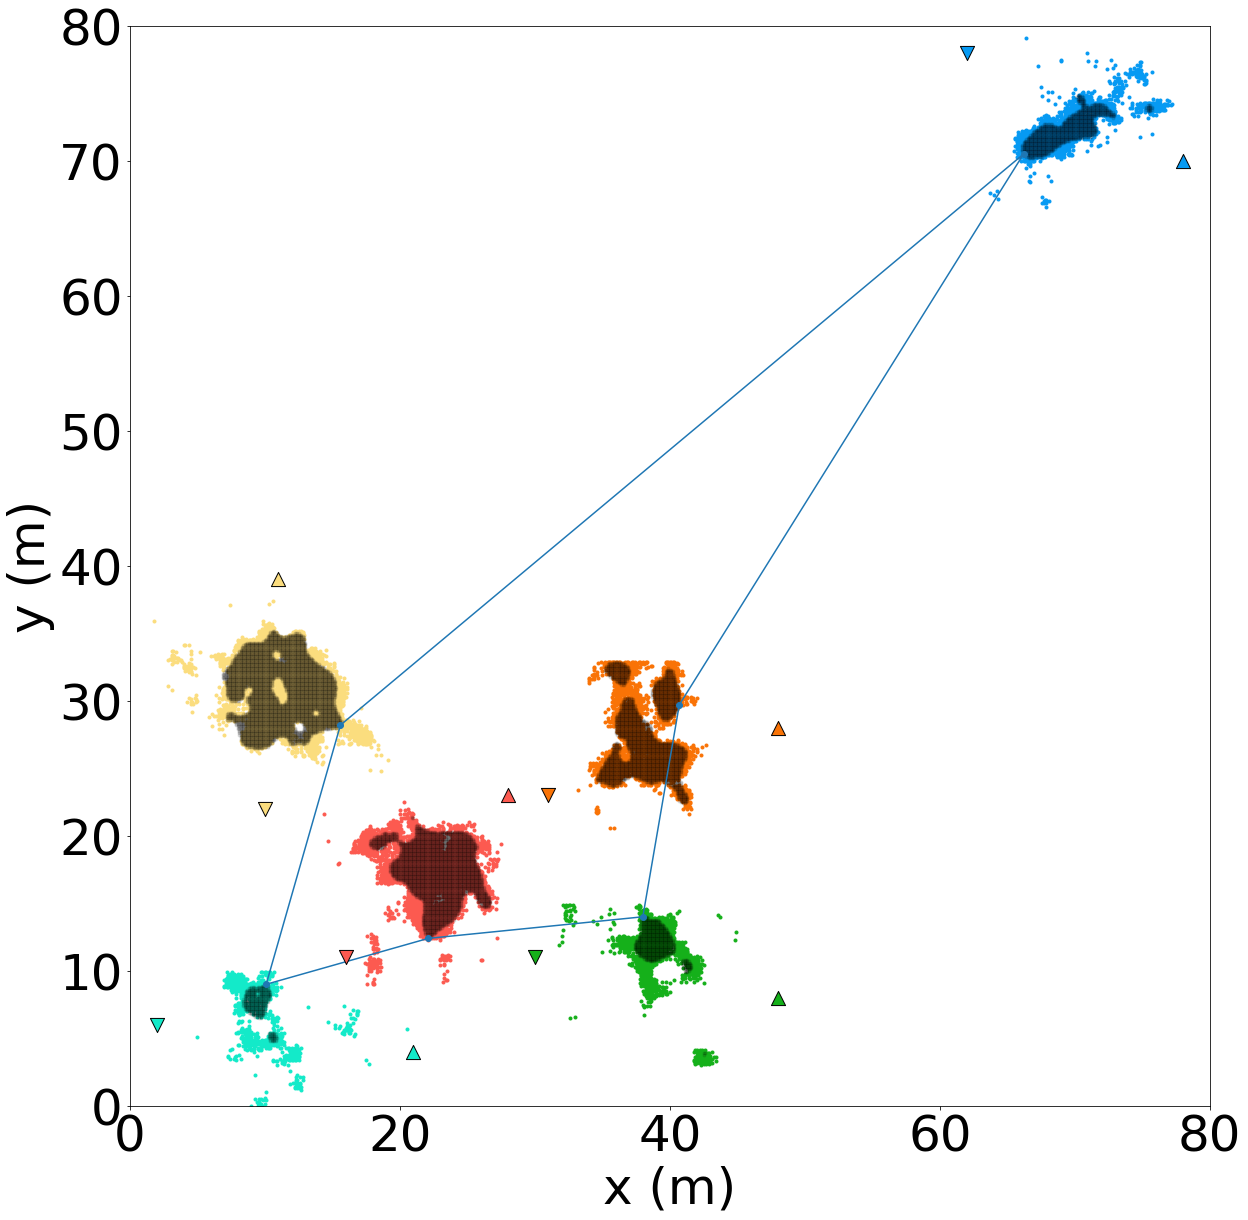

In [8]:
reload(sim)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [9]:
reload(sim)
reload(PS)
v = 1
ps = dt_sys.ps
sys_traffic = 0.8
els = np.array([0.15, 0.25, 0.15, 0.2, 0.2, 0.05])*sys_traffic/beta

ps.Ls = els

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP
Found AORP
[[0.         0.36547016 0.162416   0.20452076 0.22825872 0.03933437]
 [0.16874407 0.         0.21277055 0.26792923 0.29902677 0.05152938]
 [0.13328832 0.37817969 0.         0.21163314 0.2361966  0.04070225]
 [0.1393601  0.39540718 0.1757201  0.         0.24695623 0.04255639]
 [0.14303354 0.40582987 0.18035197 0.22710646 0.         0.04367815]
 [0.11823029 0.33545545 0.14907737 0.18772422 0.20951267 0.        ]]
[1.92 3.2  1.92 2.56 2.56 0.64]
[0.11411044 0.3237662  0.14388264 0.1811828  0.20221201 0.03484591]
[0.1285271  0.27836723 0.1566143  0.18862257 0.20510874 0.04276005]
[26.24545289 16.67954583 20.9258569  19.58390981 18.29951716 64.6818538 ]
494.408748362862
377.68907928559423


In [10]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

Velocity = 1.000000
Theotretical MB serviced: 92160.00000000001
Theoretical Energy Consumption (J): 11361.599999999993
	Th. WT	WT	E (J)	MBS	MBR
AORP	494.41	368.28	13977.93	86555.70	5657.40
Tab	---	286.30	13367.94	87821.70	4417.00
TSPN	---	333.16	13785.25	86957.05	5282.85
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

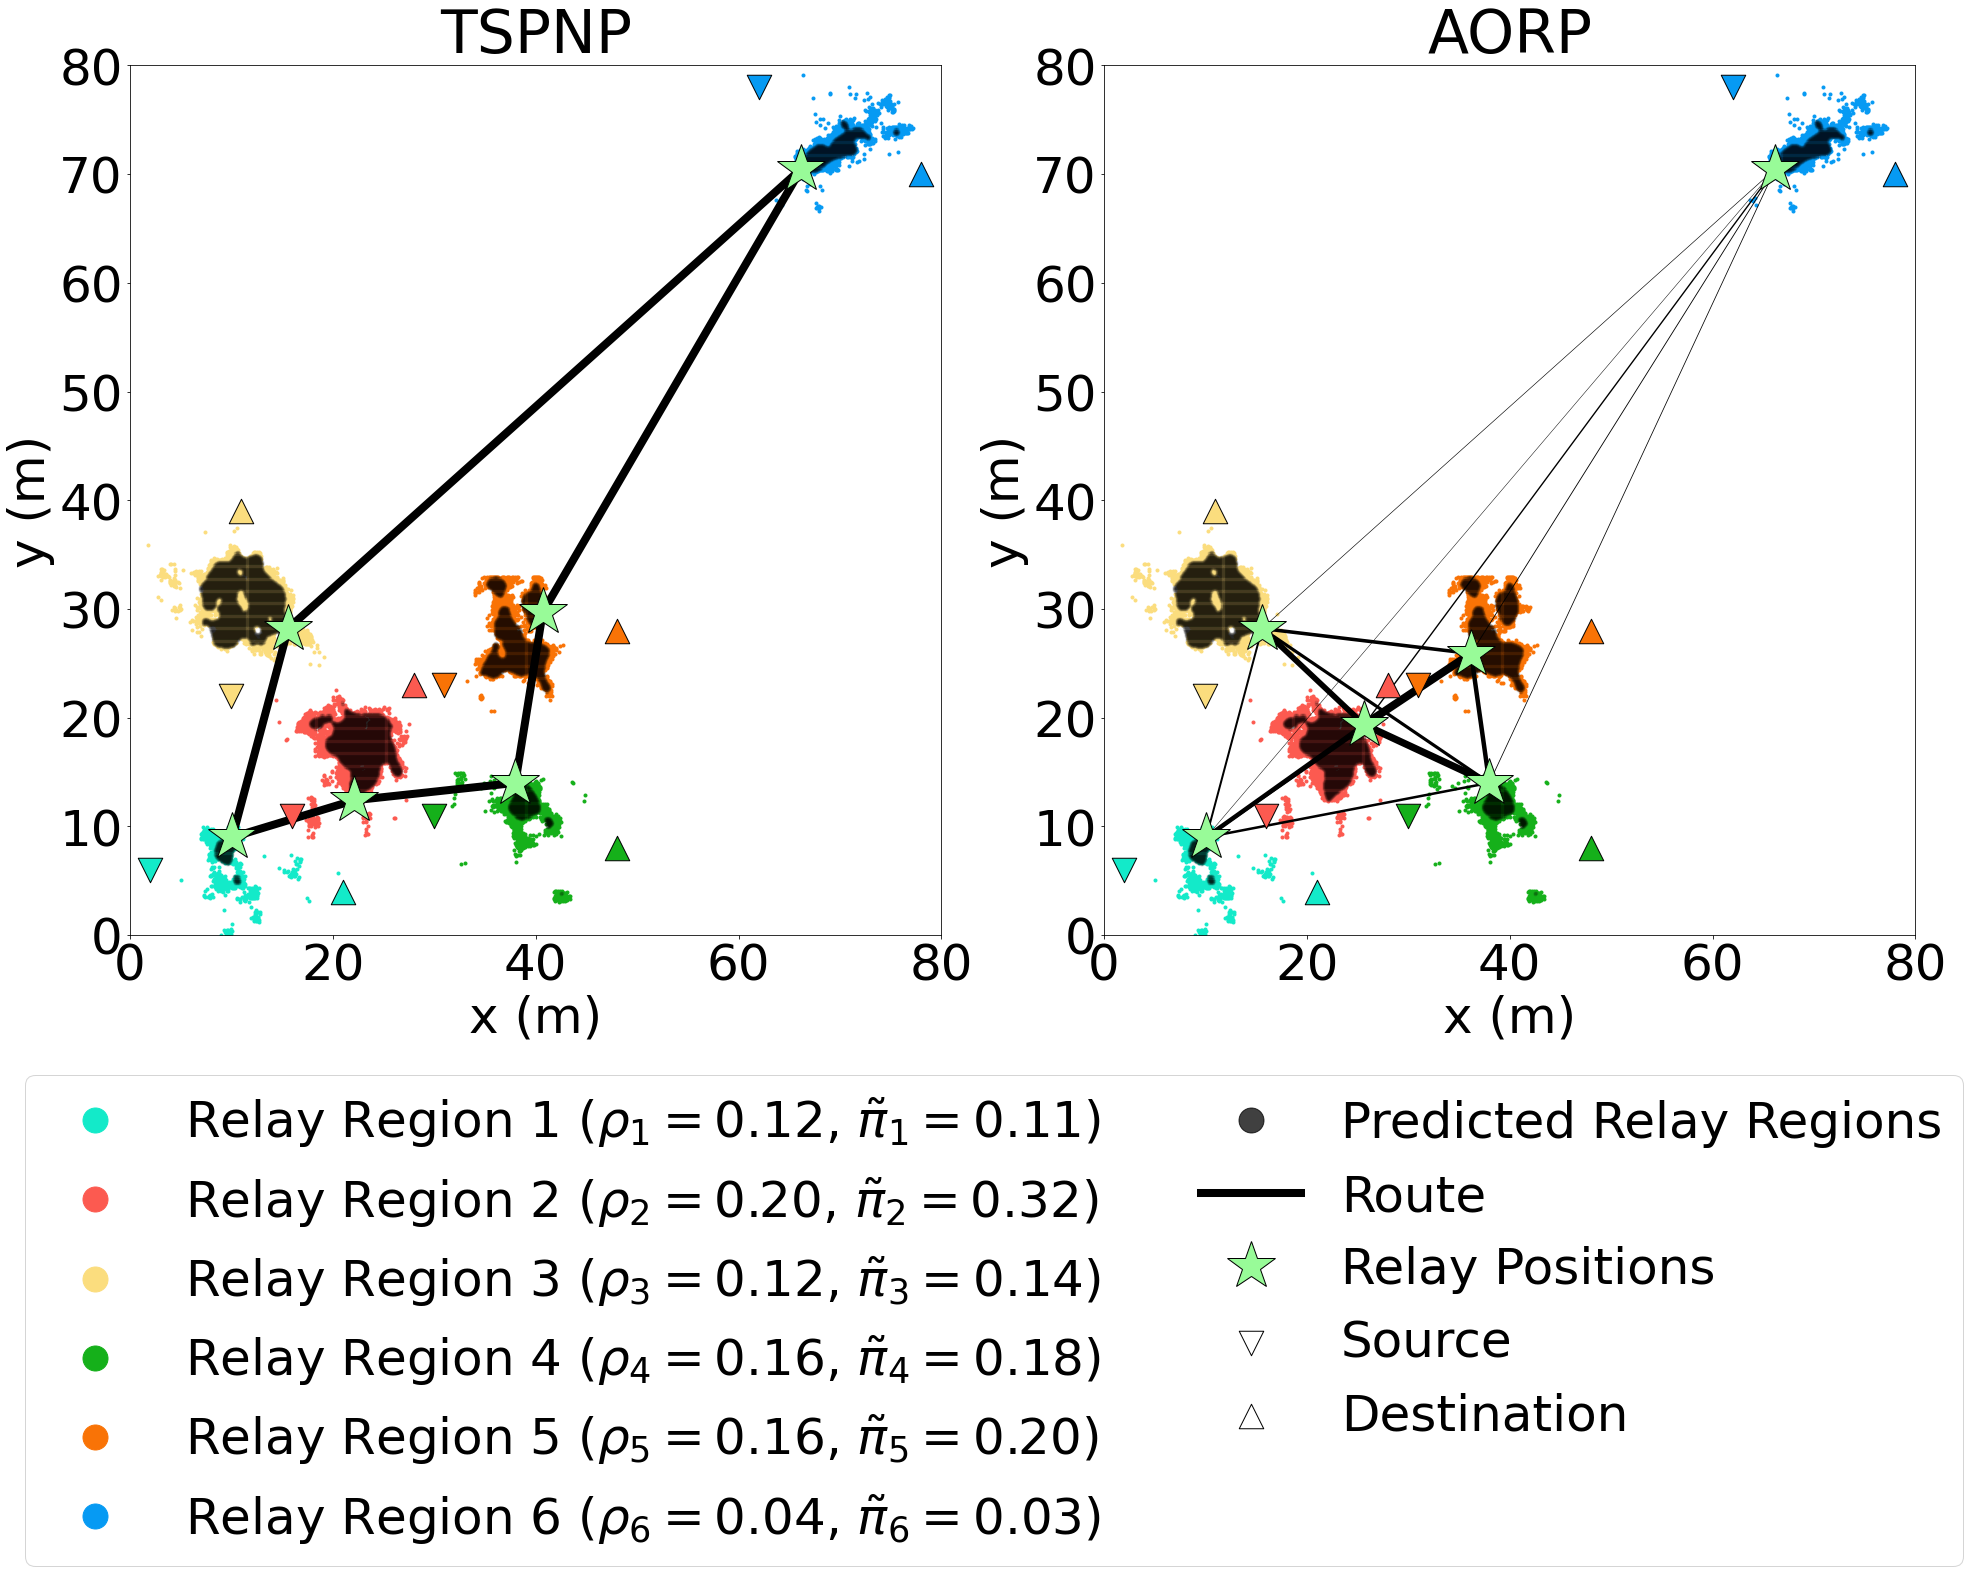

In [17]:
reload(sim)
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els*beta, AORP['pi'])

plt.savefig("six_outlier_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("six_outlier_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

In [40]:
import StaticRP as SRP
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    
W_aorp = []
W_tab = []
W_tspnp = []
s_tilde = []
dispersion = []


scales = np.array([0.005, 0.01, 0.25, 0.5, 0.75, 1, 2, 10, 30])
d = len(scales)
vals = np.tile(np.ones(n), (d,1))
vals[:,0]*=scales

sys_traffic = 0.3
L_S = sys_traffic/beta


for val in vals:
    #normalize
    val = (val/np.sum(val))*L_S
    print(val)
    ps.Ls = val
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, v)
    print("Found AORP")
    pi = AORP['pi']
    S = dtr.XtoS(AORP['X'])
    
    #also look at the tabular version
    rtable = SRP.SRPFromPis(pi, eps=0.01)
    seconds = 2*60*60
    xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
    W_tab.append(wt[-1][1])
    #S_i = S @ pi
    W_rnd = ps._calc_avg_wait_random(S, pi)
    W_aorp.append(W_rnd)
    W_cy = ps._calc_avg_wait_cyclic(S_cyv)
    W_tspnp.append(W_cy)

    P_tilde, pi_tilde = sim.pi_to_P(pi)
    S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((n,1))
    s_tilde.append(S_obs)
    
    X = AORP['X']
    X_avg = np.average(X,0, weights=val)
    diffs = X - X_avg
    dists = np.linalg.norm(diffs, axis=1)
    #normalize
    dists /= np.max(dists)
    dispersion.append(np.average(dists, weights=val))
    


[0.0047952  0.95904096 0.95904096 0.95904096 0.95904096 0.95904096]
Finding AORP
Found AORP
[0.00958084 0.95808383 0.95808383 0.95808383 0.95808383 0.95808383]
Finding AORP
Found AORP
[0.22857143 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571]
Finding AORP
Found AORP
[0.43636364 0.87272727 0.87272727 0.87272727 0.87272727 0.87272727]
Finding AORP
Found AORP
[0.62608696 0.83478261 0.83478261 0.83478261 0.83478261 0.83478261]
Finding AORP
Found AORP
[0.8 0.8 0.8 0.8 0.8 0.8]
Finding AORP
Found AORP
[1.37142857 0.68571429 0.68571429 0.68571429 0.68571429 0.68571429]
Finding AORP
Found AORP
[3.2  0.32 0.32 0.32 0.32 0.32]
Finding AORP
Found AORP
[4.11428571 0.13714286 0.13714286 0.13714286 0.13714286 0.13714286]
Finding AORP
Found AORP


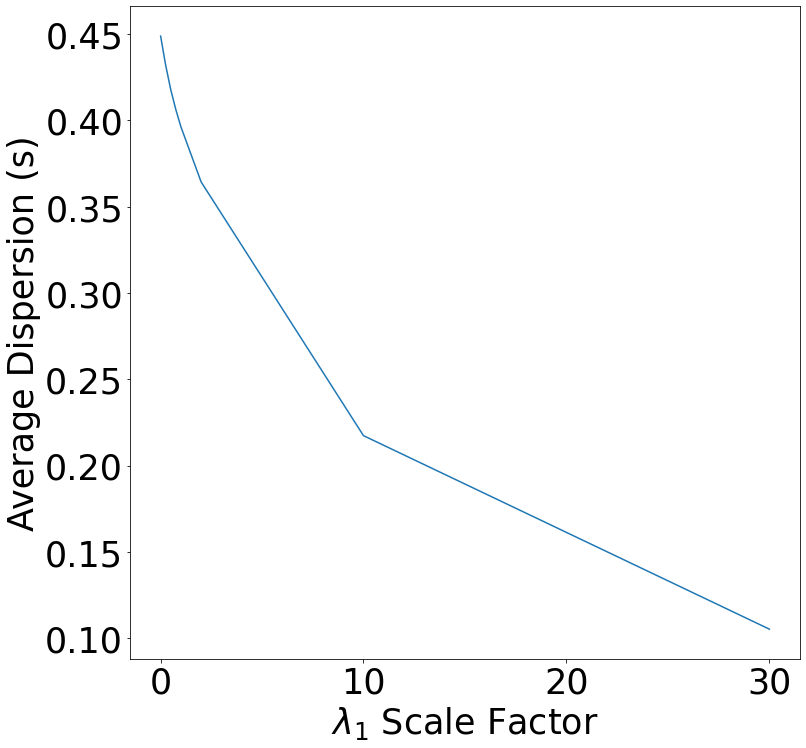

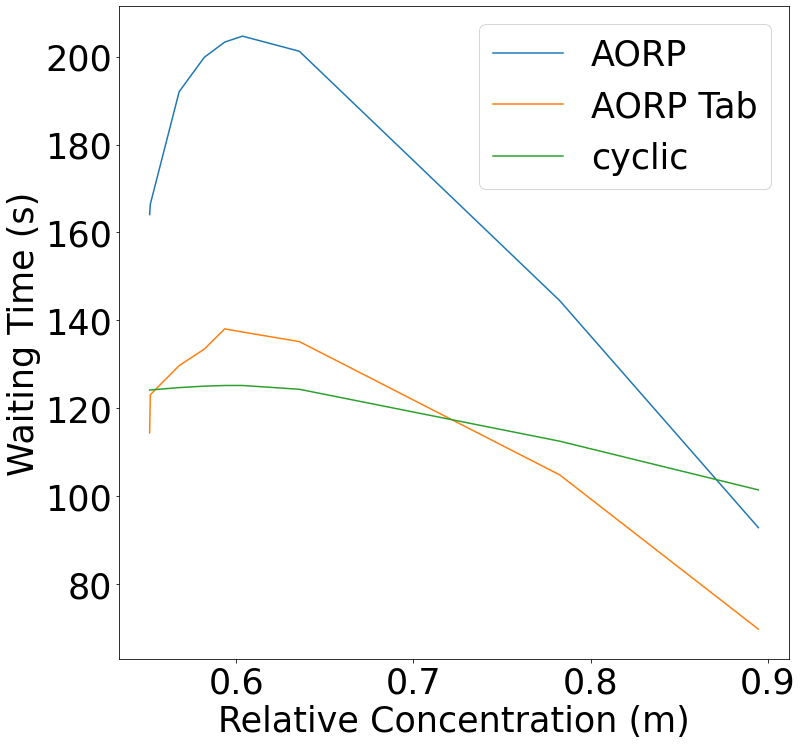

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


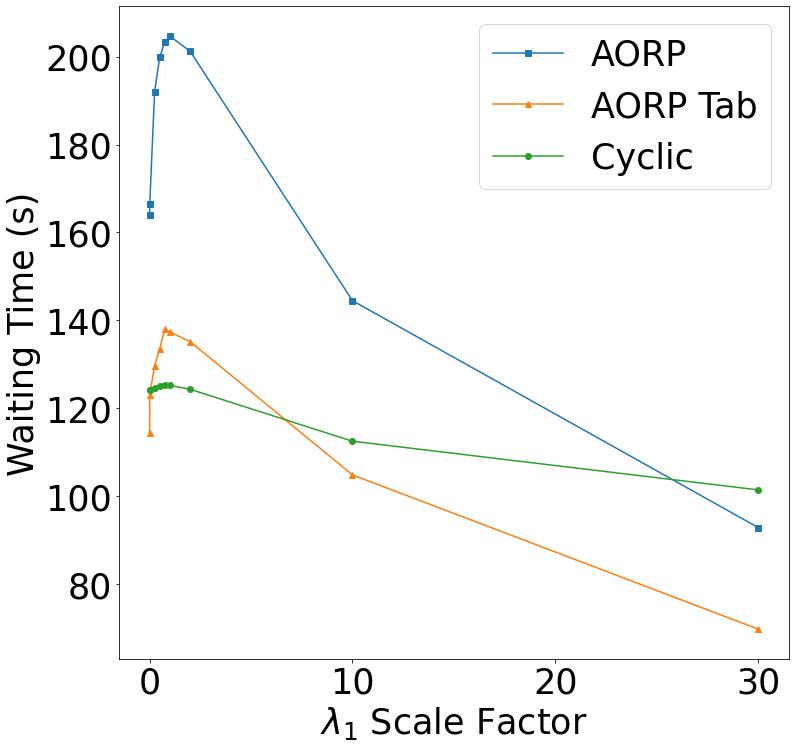

In [42]:
fig = plt.figure(figsize=(12,12))
plt.plot(scales, dispersion)
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Average Dispersion (s)")
plt.show()

dispersion = np.array(dispersion)
conc = 1-dispersion
order = np.argsort(conc).tolist()

fig = plt.figure(figsize=(12,12))
W_aorp = np.array(W_aorp)
plt.plot(conc[order], W_aorp[order], label="AORP")
W_tab = np.array(W_tab)
plt.plot(conc[order], W_tab[order],  label="AORP Tab")
W_tspnp = np.array(W_tspnp)
plt.plot(conc[order], W_tspnp[order], label="cyclic")
plt.xlabel("Relative Concentration (m)")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,12))
plt.plot(scales, W_aorp, '-s', label="AORP")
plt.plot(scales, W_tab, '-^', label="AORP Tab")
plt.plot(scales, W_tspnp, '-o', label="Cyclic")
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.savefig("outlier_w_v_scale.png", format='png', bbox_inches='tight')
plt.savefig("outlier_w_v_scale.eps", format='eps', bbox_inches='tight')
plt.show()